In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "https://imgs.xkcd.com/comics/linear_regression.png")

# SMDS MeetUp 2018-08-09: ML with AWS SageMaker and S3
> [aws sagemaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html)

1. [library imports](#library-imports)
2. [importing the iris dataset](#importing-the-iris-dataset)
3. [moving files to and from s3 from the notebook environment](#moving-files-to-and-from-s3-from-the-notebook-environment)
4. [preparing the data for model training](#preparing-the-data-for-model-training)
5. [creating a hyperparameter auto-tuning job](#creating-a-hyperparameter-auto-tuning-job)
6. [choosing a best model and creating an endpoint](#choosing-a-best-model-and-creating-an-endpoint)
7. [model assement](#model-assement)

## library imports

In [7]:
import numpy as np
import pandas as pd

# from sklearn.feature_extraction.text import CountVectorizer 
# from sklearn.externals import joblib
# from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split 
from sklearn import datasets

import matplotlib.pylab as plt
%matplotlib inline

from sagemaker import get_execution_role
import boto3
import os
import json

from time import gmtime, strftime, sleep

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## importing the iris dataset

In [2]:
iris = datasets.load_iris()
features = pd.DataFrame(iris.data)
features.columns = iris.feature_names
target = pd.DataFrame(iris.target)
target.columns = ['species']

In [3]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [4]:
features #.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [5]:
target

,species
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [6]:
target_decoder = iris.target_names
target_decoder_dict = {0:target_decoder[0], 1:target_decoder[1], 2:target_decoder[2]}
target_decoder_dict

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [7]:
iris_dataset_df = pd.concat([target, features], axis=1)
iris_dataset_df

,species,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2
5,0,5.4,3.9,1.7,0.4
6,0,4.6,3.4,1.4,0.3
7,0,5.0,3.4,1.5,0.2
8,0,4.4,2.9,1.4,0.2
9,0,4.9,3.1,1.5,0.1


## moving files to and from s3 from the notebook environment

In [4]:
def read_csv_from_s3(bucket, prefix, file_name, has_header):
    """
    function imports csv file from s3, stores into dataframe,
    and then removes from local dir (to save on disk space).
    """
    key = os.path.join(prefix, file_name)
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(key, file_name)
    if has_header:
        df = pd.read_csv(file_name)
    else:
        df = pd.read_csv(file_name, header=None)
    os.remove(file_name)
    return df

def read_json_from_s3(bucket, prefix, file_name):
    """
    function imports json from s3, stores into dictionary
    and then removes from local dir (to save on disk space)
    """
    key = os.path.join(prefix, file_name)
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(key, file_name)
    with open(file_name) as f:  
        imported_dict = json.load(f)
    os.remove(file_name)
    return imported_dict

def send_to_s3(bucket, prefix, artifact):
    """
    this function sends model artifacts to s3
    """
    fObj=open(artifact, 'rb')
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, artifact)).upload_fileobj(fObj)
    os.remove(artifact)

In [5]:
bucket = 'vfc-sagemaker-naas'
prefix = 'sagemaker/ds_meetup_20180809'

In [10]:
iris_dataset_df.to_csv('iris_dataset.csv', index = False) 

send_to_s3(
    bucket = bucket,
    prefix = os.path.join(prefix, 'iris_dataset'), 
    artifact = 'iris_dataset.csv'
)

In [11]:
iris_df = read_csv_from_s3(
    bucket = bucket,
    prefix = os.path.join(prefix, 'iris_dataset'),
    file_name = 'iris_dataset.csv',
    has_header = True
)

In [12]:
iris_df.head(10)

,species,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2
5,0,5.4,3.9,1.7,0.4
6,0,4.6,3.4,1.4,0.3
7,0,5.0,3.4,1.5,0.2
8,0,4.4,2.9,1.4,0.2
9,0,4.9,3.1,1.5,0.1


## preparing the data for model training

In [13]:
# separate target from features for train/test split
target = iris_df['species']
features = iris_df[[f for f in iris_df.columns if f != 'species']]
# target = iris_df.iloc[:, 0]
# features = iris_df.iloc[:, 1:]

In [14]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: species, dtype: int64

In [15]:
features.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [16]:
class_sizes = iris_df['species'].value_counts()
class_sizes

2    50
1    50
0    50
Name: species, dtype: int64

In [17]:
# set train, dev/validation and test set sizes
test_sz = int(.1 * len(iris_df))
validation_sz = int(.2 * len(iris_df))
train_sz = int(.7 * len(iris_df))

In [18]:
# first round of sampling yields a test set and a combined train/validate set, which will be split
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    train_size = train_sz + validation_sz,
    test_size = test_sz,
    stratify = target, 
    random_state = 42
)

# recombine target and features
train_validation_df = pd.concat([target_train, features_train], axis=1)
test_df = pd.concat([target_test, features_test], axis=1)

In [19]:
train_validation_df.head()

,species,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
29,0,4.7,3.2,1.6,0.2
145,2,6.7,3.0,5.2,2.3
8,0,4.4,2.9,1.4,0.2
148,2,6.2,3.4,5.4,2.3
25,0,5.0,3.0,1.6,0.2


In [20]:
print('train/validate combined df record count: ' + str(len(train_validation_df)))

train/validate combined df record count: 135


In [21]:
test_df.head()

,species,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
58,1,6.6,2.9,4.6,1.3
134,2,6.1,2.6,5.6,1.4
147,2,6.5,3.0,5.2,2.0
69,1,5.6,2.5,3.9,1.1
107,2,7.3,2.9,6.3,1.8


In [22]:
print('test combined df record count: ' + str(len(test_df)))

test combined df record count: 15


In [23]:
# separate target from features (train/validation set) for second round of train/test split

target = train_validation_df['species']
features = train_validation_df[[f for f in iris_df.columns if f != 'species']]

# second round of sampling yields train and validation sets 

features_train, features_validation, target_train, target_validation = train_test_split(
    features, 
    target, 
    train_size = train_sz,
    test_size = validation_sz,
    stratify = target, 
    random_state = 42
)

train_df = pd.concat([target_train, features_train], axis=1)
validation_df = pd.concat([target_validation, features_validation], axis=1)

In [24]:
train_df.head()

,species,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
90,1,5.5,2.6,4.4,1.2
118,2,7.7,2.6,6.9,2.3
0,0,5.1,3.5,1.4,0.2
9,0,4.9,3.1,1.5,0.1
45,0,4.8,3.0,1.4,0.3


In [25]:
print('test combined df record count: ' + str(len(train_df)))

test combined df record count: 105


In [26]:
validation_df.head()

,species,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
82,1,5.8,2.7,3.9,1.2
87,1,6.3,2.3,4.4,1.3
60,1,5.0,2.0,3.5,1.0
106,2,4.9,2.5,4.5,1.7
33,0,5.5,4.2,1.4,0.2


In [27]:
print('test combined df record count: ' + str(len(validation_df)))

test combined df record count: 30


In [28]:
# xgboost model expects index = False and header = False

train_df.to_csv('train.csv', index = False, header = False)

send_to_s3(
    bucket = bucket,
    prefix = os.path.join(prefix, 'train_and_dev_datasets/train'), 
    artifact = 'train.csv'
)

validation_df.to_csv('validation.csv', index = False, header = False)

send_to_s3(
    bucket = bucket,
    prefix = os.path.join(prefix, 'train_and_dev_datasets/validation'), 
    artifact = 'validation.csv'
)

In [55]:
# send test_df to csv ... we will read this back in later on for testing

test_df.to_csv('test.csv', index=False, header=False)

send_to_s3(
    bucket = bucket,
    prefix = prefix,
    artifact = 'test.csv'
)

In [29]:
num_classes = len(iris_df['species'].drop_duplicates())

num_classes_dict = {'num_classes': num_classes}

with open('num_classes_dict.json', 'w') as f:
    json.dump(num_classes_dict, f)
    
# send num_classes_dict to s3
send_to_s3(
    bucket = bucket, 
    prefix = prefix, 
    artifact = 'num_classes_dict.json'
)

In [30]:
target_decoder_dict

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [31]:
with open('target_decoder_dict.json', 'w') as f:
    json.dump(target_decoder_dict, f)
    
# send num_classes_dict to s3
send_to_s3(
    bucket = bucket, 
    prefix = prefix, 
    artifact = 'target_decoder_dict.json'
)

## creating a hyperparameter auto-tuning job

In [32]:
tuning_job_prefix = 'naas-ds-meetup'
tuning_job_name = tuning_job_prefix + '-' + strftime("%Y%m%d%H%M", gmtime())

"""
We will tune four hyperparameters in this examples:

    eta: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly 
        get the weights of new features. The eta parameter actually shrinks the feature weights to make the 
        boosting process more conservative.
        
    alpha: L1 regularization term on weights. Increasing this value makes models more conservative.
    
    min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step 
        results in a leaf node with the sum of instance weight less than min_child_weight, the building process 
        gives up further partitioning. In linear regression models, this simply corresponds to a minimum number 
        of instances needed in each node. The larger the algorithm, the more conservative it is.
        
    max_depth: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be 
        overfitted.
"""

tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta",
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight",
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha",            
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth",
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 10,
      "MaxParallelTrainingJobs": 2
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:merror",
      "Type": "Minimize"
    }
  }

# NOTE, we are monitoring the Validation set error rate 

In [33]:
region = boto3.Session().region_name
role = get_execution_role()

containers = {
    'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
    'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
    'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
    'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'
}

training_image = containers[region]
     
s3_input_train = 's3://{}/{}/train'.format(bucket, os.path.join(prefix, 'train_and_dev_datasets'))
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, os.path.join(prefix, 'train_and_dev_datasets'))
    
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/output".format(os.path.join(bucket, prefix,'sagemaker_model',tuning_job_name)) 
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.10xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "merror",
      "num_class": str(num_classes),
      "num_round": "100",
      "objective": "multi:softprob",
      "rate_drop": "0.3"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 432000
    }
}

In [34]:
smclient = boto3.Session().client('sagemaker')

smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = tuning_job_name,
    HyperParameterTuningJobConfig = tuning_job_config,
    TrainingJobDefinition = training_job_definition
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:437061375727:hyper-parameter-tuning-job/naas-ds-meetup-201808091453',
 'ResponseMetadata': {'RequestId': 'd79d70ff-bdc9-4a7b-b797-f6e75ed4d410',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd79d70ff-bdc9-4a7b-b797-f6e75ed4d410',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '128',
   'date': 'Thu, 09 Aug 2018 14:53:55 GMT'},
  'RetryAttempts': 0}}

In [42]:
# run this cell to check current status of hyperparameter tuning job

tuning_job_result = smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Warning: The master tuning job has not yet completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
total_jobs = tuning_job_config['ResourceLimits']['MaxNumberOfTrainingJobs']
print("%d training jobs of %d have completed" % (job_count, total_jobs))

10 training jobs of 10 have completed


## choosing a best model and creating an endpoint

In [43]:
best_tuning_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']
best_tuning_job_name

'naas-ds-meetup-201808091453-003-c59a7b22'

In [44]:
"""
We can list hyperparameters and objective metrics of all training
jobs and pick up the training job with the best objective metric.
"""

is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

import sagemaker

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 10
{'lowest': 0.06666699796915054, 'highest': 0.6666669845581055}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,eta,max_depth,min_child_weight
0,0.066667,80.0,2018-08-09 15:12:37+00:00,naas-ds-meetup-201808091453-010-5984f7b4,Completed,2018-08-09 15:11:17+00:00,1.851366,0.360612,10.0,2.741486
1,0.066667,79.0,2018-08-09 15:11:49+00:00,naas-ds-meetup-201808091453-009-2d59432c,Completed,2018-08-09 15:10:30+00:00,1.584764,0.477312,9.0,6.793068
2,0.066667,77.0,2018-08-09 15:07:58+00:00,naas-ds-meetup-201808091453-008-421cbe20,Completed,2018-08-09 15:06:41+00:00,1.509386,0.679368,4.0,2.768128
3,0.066667,81.0,2018-08-09 15:08:04+00:00,naas-ds-meetup-201808091453-007-f9bd4ef7,Completed,2018-08-09 15:06:43+00:00,1.509386,0.679368,4.0,2.948128
7,0.066667,82.0,2018-08-09 15:00:40+00:00,naas-ds-meetup-201808091453-003-c59a7b22,Completed,2018-08-09 14:59:18+00:00,1.979234,0.253546,5.0,8.638496
4,0.100000,76.0,2018-08-09 15:04:32+00:00,naas-ds-meetup-201808091453-006-37663e5b,Completed,2018-08-09 15:03:16+00:00,0.186388,0.996873,1.0,3.344910
8,0.100000,71.0,2018-08-09 14:57:08+00:00,naas-ds-meetup-201808091453-002-b6a61096,Completed,2018-08-09 14:55:57+00:00,0.015020,0.315345,3.0,1.024491
9,0.100000,79.0,2018-08-09 14:57:48+00:00,naas-ds-meetup-201808091453-001-8e4ab295,Completed,2018-08-09 14:56:29+00:00,0.287481,0.422420,3.0,4.261082
5,0.666667,81.0,2018-08-09 15:04:06+00:00,naas-ds-meetup-201808091453-005-2a7158d1,Completed,2018-08-09 15:02:45+00:00,1.998033,0.000000,8.0,5.499702
6,0.666667,74.0,2018-08-09 15:00:58+00:00,naas-ds-meetup-201808091453-004-a1847fe7,Completed,2018-08-09 14:59:44+00:00,1.713243,0.000000,7.0,8.989510


In [45]:
"""
Next we will show how the objective metric changes over time, as the tuning job progresses. 
For Bayesian strategy, you should expect to see a general trend towards better results, but 
this progress will not be steady as the algorithm needs to balance exploration of new areas 
of parameter space against exploitation of known good areas. This can give you a sense of 
whether or not the number of training jobs is sufficient for the complexity of your search space.
"""

import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

In [46]:
"""
Now you have finished a tuning job, you may want to know the correlation between your objective metric 
and individual hyperparameters you've selected to tune. Having that insight will help you decide whether 
it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For exmaple, 
if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set 
a higher tuning range for that hyperparameter in your next tuning job.  The following cell draws a graph for 
each hyperparameter to show its correlation with your objective metric.
"""

ranges = tuner.tuning_ranges

figures = []

for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(
        plot_width=500, plot_height=500, 
        title="Objective vs %s" % hp_name,
        tools=hover.tools(),
        x_axis_label=hp_name, y_axis_label=objective_name,**categorical_args
    )
    
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
    
show(bokeh.layouts.Column(*figures))

In [47]:
tuning_job_prefix

'naas-ds-meetup'

In [49]:
# create model from best tuning job

model_name = tuning_job_prefix + '-model'

info = smclient.describe_training_job(TrainingJobName=best_tuning_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']

training_image = containers[region]

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data
}

create_model_response = smclient.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container
)

In [50]:
# create endpoint config from model

endpoint_config_name = tuning_job_prefix + '-endpoint-config'

create_endpoint_config_response = smclient.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [
        {'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}
    ]
)

In [51]:
# create endpoint from endpoint config...

endpoint_name = tuning_job_prefix + '-endpoint'

create_endpoint_response = smclient.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

In [52]:
# ...and write its name to a dict for ref in testing phase

endpoint_name_dict = {'endpoint_name': endpoint_name}

with open('endpoint_name_dict.json', 'w') as f:
    json.dump(endpoint_name_dict, f)
    
# send endpoint_name_dict.json to s3
send_to_s3(
    bucket = bucket, 
    prefix = prefix, 
    artifact = 'endpoint_name_dict.json'
)

## model assement

In [8]:
# read in test set from s3
test_df = read_csv_from_s3(
    bucket = bucket,
    prefix = prefix,
    file_name = 'test.csv',
    has_header = False
)

In [9]:
test_df

,0,1,2,3,4
0,1,6.6,2.9,4.6,1.3
1,2,6.1,2.6,5.6,1.4
2,2,6.5,3.0,5.2,2.0
3,1,5.6,2.5,3.9,1.1
4,2,7.3,2.9,6.3,1.8
5,0,4.4,3.2,1.3,0.2
6,0,4.4,3.0,1.3,0.2
7,0,5.0,3.4,1.5,0.2
8,2,6.4,2.8,5.6,2.2
9,1,6.6,3.0,4.4,1.4


In [10]:
print('number of test cases: ' + str(len(test_df)))

number of test cases: 15


In [11]:
# separate target and predictors for testing
test_y = test_df.iloc[:, 0]
test_y = test_y.rename('true_label')

test_X = test_df.iloc[:, 1:]
test_X.to_csv('test_X.csv', index = False, header = False)

test_file = 'test_X.csv'

with open(test_file) as f:
    payload = f.read()

test_data = payload.split('\n')

os.remove('test_X.csv')

In [12]:
# batch testing functions

runtime_client = boto3.client('runtime.sagemaker')

def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(
        EndpointName = endpoint_name, 
        ContentType = content_type, 
        Body = payload
    )
    result = response['Body'].read().decode('ascii')
    preds = [probs for probs in result.replace('[', '').replace(']','').split(',') ]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    for offset in range(0, items-1, batch_size):
        arrs.extend(
            do_predict(
                data[offset:min(offset+batch_size, items)], 
                endpoint_name, 
                content_type
            )
        )
    return(arrs)

In [13]:
# import endpoint name dict
endpoint_name_dict = read_json_from_s3(
    bucket = bucket,
    prefix = prefix,
    file_name = 'endpoint_name_dict.json'
)

endpoint_name = endpoint_name_dict['endpoint_name']
endpoint_name

'naas-ds-meetup-endpoint'

In [14]:
# get preds
probs = batch_predict(
    data = test_data, 
    batch_size = 15, 
    endpoint_name = endpoint_name, 
    content_type = 'text/csv'
)

In [15]:
# import num_classes
num_classes_dict = read_json_from_s3(
    bucket = bucket,
    prefix = prefix,
    file_name = 'num_classes_dict.json'
)

num_classes = num_classes_dict['num_classes']

num_classes

3

In [16]:
# reshape the probs list into a num records * num classes data frame where
# each numberic column header maps to a class (by way of mapping dict)
probs_df = pd.DataFrame(np.array(probs).reshape(len(test_X), num_classes))
probs_df = probs_df.astype(float).round(4)
probs_df

,0,1,2
0,0.0673,0.8624,0.0703
1,0.0980,0.5588,0.3432
2,0.0486,0.0752,0.8762
3,0.0674,0.8637,0.0689
4,0.0482,0.0836,0.8682
5,0.8771,0.0741,0.0488
6,0.8771,0.0741,0.0488
7,0.8771,0.0741,0.0488
8,0.0482,0.0836,0.8682
9,0.0743,0.8481,0.0776


In [17]:
# get best top prob for each row and the corresponding column label
best_pred_label_df = probs_df.idxmax(axis=1)
best_pred_label_df = best_pred_label_df.rename('best_pred_label')
best_pred_label_df

0     1
1     1
2     2
3     1
4     2
5     0
6     0
7     0
8     2
9     1
10    0
11    2
12    1
13    2
14    0
Name: best_pred_label, dtype: int64

In [18]:
best_pred_prob_df = probs_df.max(axis=1)
best_pred_prob_df = best_pred_prob_df.rename('confidence')
best_pred_prob_df

0     0.8624
1     0.5588
2     0.8762
3     0.8637
4     0.8682
5     0.8771
6     0.8771
7     0.8771
8     0.8682
9     0.8481
10    0.8771
11    0.8762
12    0.8481
13    0.8762
14    0.8771
Name: confidence, dtype: float64

In [19]:
true_label_and_best_pred_df = pd.concat([test_y, best_pred_label_df], axis=1)
true_label_and_best_pred_df = pd.concat([true_label_and_best_pred_df, best_pred_prob_df], axis=1)
true_label_and_best_pred_df

,true_label,best_pred_label,confidence
0,1,1,0.8624
1,2,1,0.5588
2,2,2,0.8762
3,1,1,0.8637
4,2,2,0.8682
5,0,0,0.8771
6,0,0,0.8771
7,0,0,0.8771
8,2,2,0.8682
9,1,1,0.8481


In [20]:
correct_preds = sum(
    true_label_and_best_pred_df['true_label'] == true_label_and_best_pred_df['best_pred_label']
)

tot_preds = len(true_label_and_best_pred_df)

accuracy_rt = round(float(correct_preds/tot_preds),4)
accuracy_rt

0.8667

In [22]:
# read in encoded_ps_code_mapping_dict.json
target_decoder_dict = read_json_from_s3(
    bucket = bucket,
    prefix = prefix,
    file_name = 'target_decoder_dict.json'
)

#target_decoder_dict = {int(k):v for k,v in encoded_ps_code_mapping_dict.items()}

target_decoder_dict

{'0': 'setosa', '1': 'versicolor', '2': 'virginica'}

In [23]:
# read in encoded_ps_code_mapping_dict.json, this time transforming the keys from str() to int()
target_decoder_dict = read_json_from_s3(
    bucket = bucket,
    prefix = prefix,
    file_name = 'target_decoder_dict.json'
)

target_decoder_dict = {int(k):v for k,v in target_decoder_dict.items()}

target_decoder_dict

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [24]:
# map the integer classes for true_labels to a species
true_label_and_best_pred_df['true_label'].replace(target_decoder_dict, inplace = True)

# map the integer classes for best_pred_label to a species 
true_label_and_best_pred_df['best_pred_label'].replace(target_decoder_dict, inplace = True)

In [25]:
true_label_and_best_pred_df

,true_label,best_pred_label,confidence
0,versicolor,versicolor,0.8624
1,virginica,versicolor,0.5588
2,virginica,virginica,0.8762
3,versicolor,versicolor,0.8637
4,virginica,virginica,0.8682
5,setosa,setosa,0.8771
6,setosa,setosa,0.8771
7,setosa,setosa,0.8771
8,virginica,virginica,0.8682
9,versicolor,versicolor,0.8481


In [30]:
true_label_and_best_pred_df['is_accurate'] = (
    true_label_and_best_pred_df['true_label'] == true_label_and_best_pred_df['best_pred_label']
).astype(int)

In [32]:
true_label_and_best_pred_df

,true_label,best_pred_label,confidence,is_accurate
0,versicolor,versicolor,0.8624,1
1,virginica,versicolor,0.5588,0
2,virginica,virginica,0.8762,1
3,versicolor,versicolor,0.8637,1
4,virginica,virginica,0.8682,1
5,setosa,setosa,0.8771,1
6,setosa,setosa,0.8771,1
7,setosa,setosa,0.8771,1
8,virginica,virginica,0.8682,1
9,versicolor,versicolor,0.8481,1


In [26]:
def multiclass_confusion_matrix(df,cols):
    """
    This function accepts a dataframe and a refence to two series in that df, which are 
    used to create the crosstabs.  A list containing each confusion matrix (crosstab) is returned.
    """
    df_copy = df.copy()
    confusion_matrices = []
    for target in df_copy[cols[0]].drop_duplicates():
        df_copy['binary_true_label'] = np.where(df_copy[cols[0]]==target, target, 'not_' + target)
        df_copy['binary_pred_label'] = np.where(df_copy[cols[1]]==target, target, 'not_' + target)
        cm = pd.crosstab(df_copy['binary_true_label'], df_copy['binary_pred_label'])
        confusion_matrices.append(cm)
    return confusion_matrices

In [27]:
confusion_matrices = multiclass_confusion_matrix(
    df = true_label_and_best_pred_df,
    cols = ['true_label','best_pred_label']
)

In [33]:
for cm in confusion_matrices:
    print(cm)
    print('')

binary_pred_label  not_versicolor  versicolor
binary_true_label                            
not_versicolor                  9           1
versicolor                      1           4

binary_pred_label  not_virginica  virginica
binary_true_label                          
not_virginica                  9          1
virginica                      1          4

binary_pred_label  not_setosa  setosa
binary_true_label                    
not_setosa                 10       0
setosa                      0       5



Test error: 13.3%


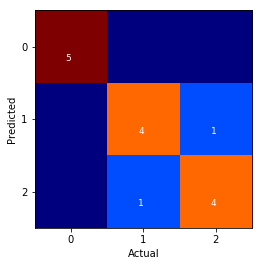

In [42]:
inv_target_decoder_dict = {v:k for k,v in target_decoder_dict.items()}
cm_df = true_label_and_best_pred_df.copy()
cm_df['true_label'].replace(inv_target_decoder_dict, inplace = True)
cm_df['best_pred_label'].replace(inv_target_decoder_dict, inplace = True)

def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]
    error = 100.0 - (100 * float(correct) / float(total))
    confusions = np.zeros([num_classes, num_classes], np.int32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[int(predicted), int(actual)] += 1
    
    return error, confusions

NUM_LABELS = num_classes
test_error, confusions = error_rate(np.asarray(cm_df['best_pred_label']), np.asarray(cm_df['true_label']))
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

In [ ]:
# you get charged the per hour your endpoint is up...
smclient.delete_endpoint(EndpointName=endpoint_name)